Training samples: 5740
Validation samples: 1230
Test samples: 1231
Augmented training samples: 17220

=== MODEL SUMMARY ===


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 8)              │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10, 8)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 10)         │            90 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,242 (4.85 KB)

 Trainable params: 1,242 (4.85 KB)

 Non-trainable params: 0 (0.00 B)

None

=== MULAI TRAINING ===
Epoch 1/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 1.4168 - mae: 0.2138 - val_loss: 1.4009 - val_mae: 0.2621 - learning_rate: 5.0000e-05
Epoch 2/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3803 - mae: 0.2133 - val_loss: 1.3653 - val_mae: 0.2618 - learning_rate: 5.0000e-05
Epoch 3/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3442 - mae: 0.2114 - val_loss: 1.3306 - val_mae: 0.2615 - learning_rate: 5.0000e-05
Epoch 4/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3093 - mae: 0.2101 - val_loss: 1.2967 - val_mae: 0.2611 - learning_rate: 5.0000e-05
Epoch 5/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2759 - mae: 0.2102 - val_loss: 1.2637 - val_mae: 0.2607 - learning_rate: 5.0000e-05
Epoch 6/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2427 - mae: 0.2088 - val_loss: 1.2315 - val_mae: 0.2602 - learning_rate: 5.0000e-05
Epoch 7/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2104 - mae: 0.2080 - val_loss: 1.2001 - 

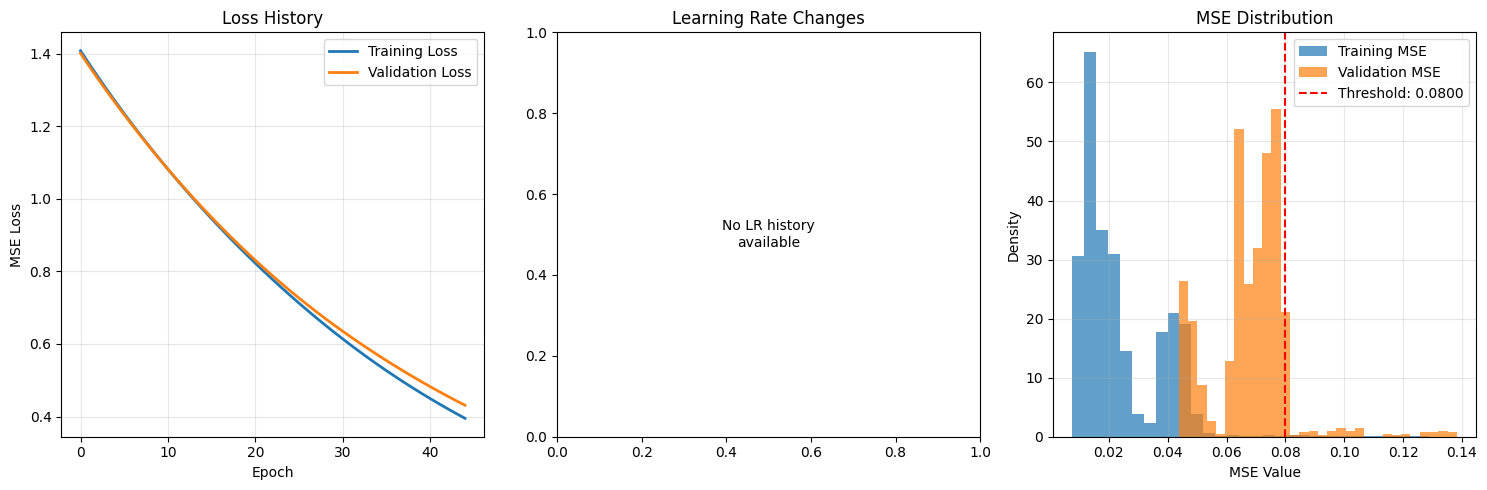


=== OVERFITTING CHECK ===
Final Training Loss: 0.394978
Final Validation Loss: 0.430996
Validation/Training Ratio: 1.091
✅ Model tidak overfitting (ratio < 1.2)

=== SELESAI ===
Model anti-overfitting berhasil dilatih dan disimpan!
File yang tersimpan:
- lstm_autoencoder_anti_overfit.keras
- scaler_anti_overfit.pkl
- thresholds_anti_overfit.pkl


In [5]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def detect_outliers_by_distance(df, columns_to_check, threshold_std=2):
    outlier_indices = set()
    for col in columns_to_check:
        deltas = np.abs(df[col].diff())
        delta_mean = deltas[1:].mean()
        delta_std = deltas[1:].std()
        threshold = delta_mean + (threshold_std * delta_std)
        outlier_mask = deltas > threshold
        col_outliers = df[outlier_mask].index.tolist()
        outlier_indices.update(col_outliers)
    return sorted(list(outlier_indices))

def create_sliding_windows(array, window_size):
    sequences = []
    for i in range(len(array) - window_size + 1):
        sequences.append(array[i: i + window_size])
    return np.array(sequences)

def add_noise(data, noise_factor=0.02):
    """Menambahkan noise untuk data augmentation"""
    noise = np.random.normal(0, noise_factor, data.shape)
    return data + noise

# Load dan preprocessing data
df = pd.read_csv('LinearDatas.csv', sep=';', decimal=',')
df['created_at'] = pd.to_datetime(df['created_at'])

columns_to_check = ['mem_used', 'root_used', 'log_used', 'fw_total_alloc', 'total_rx_packets', 'total_tx_packets']
outlier_indices = detect_outliers_by_distance(df, columns_to_check, threshold_std=2)

normal_indices = [i for i in df.index if i not in outlier_indices]
df_normal = df.loc[normal_indices].reset_index(drop=True)

numeric_df_normal = df_normal.drop(columns=['created_at'])
numeric_data_normal = numeric_df_normal.values

# Scaling dengan robust scaler approach
scaler_normal = MinMaxScaler(feature_range=(0.1, 0.9))
data_scaled_normal = scaler_normal.fit_transform(numeric_data_normal)

# Gunakan scaling sederhana tanpa log transform
data_final = data_scaled_normal

# Window size
window_size = 10

sequences_normal = create_sliding_windows(data_final, window_size)

# Split data dengan proporsi yang lebih konservatif
split_idx_train = int(0.7 * len(sequences_normal))
split_idx_val = int(0.85 * len(sequences_normal))

X_train = sequences_normal[:split_idx_train]
X_val = sequences_normal[split_idx_train:split_idx_val]
X_test = sequences_normal[split_idx_val:]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Data augmentation dengan multiple noise levels
X_train_noisy1 = add_noise(X_train, noise_factor=0.01)
X_train_noisy2 = add_noise(X_train, noise_factor=0.02)
X_train_augmented = np.concatenate([X_train, X_train_noisy1, X_train_noisy2], axis=0)
X_train_target = np.concatenate([X_train, X_train, X_train], axis=0)

print(f"Augmented training samples: {len(X_train_augmented)}")

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Model yang sangat sederhana untuk mengatasi overfitting parah
input_layer = Input(shape=(timesteps, n_features))

# Encoder - sangat sederhana, hanya 1 layer
encoder = LSTM(8, activation='tanh', return_sequences=False, 
               kernel_regularizer=l2(0.05), dropout=0.4, recurrent_dropout=0.4)(input_layer)

# Bottleneck dengan dropout sangat agresif
bottleneck = Dropout(0.8)(encoder)

# Decoder - juga sederhana
repeat = RepeatVector(timesteps)(bottleneck)
decoder = LSTM(8, activation='tanh', return_sequences=True, 
               kernel_regularizer=l2(0.05), dropout=0.4, recurrent_dropout=0.4)(repeat)

# Output layer
output_layer = TimeDistributed(Dense(n_features, activation='sigmoid'))(decoder)

model = Model(inputs=input_layer, outputs=output_layer)

# Optimizer dengan learning rate yang sangat kecil
optimizer = Adam(learning_rate=0.00005, clipnorm=0.5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks yang sangat agresif untuk mencegah overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7, verbose=1)

print("\n=== MODEL SUMMARY ===")
print(model.summary())

# Training dengan strategi anti-overfitting yang sangat agresif
print("\n=== MULAI TRAINING ===")
history = model.fit(
    X_train_augmented, X_train_target,
    epochs=45,
    batch_size=256,
    validation_data=(X_val, X_val),
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluasi pada training dan validation data
print("\n=== EVALUASI MODEL ===")
X_train_pred = model.predict(X_train, batch_size=256, verbose=0)
X_val_pred = model.predict(X_val, batch_size=256, verbose=0)

mse_train = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))
mse_val = np.mean(np.square(X_val - X_val_pred), axis=(1, 2))

print(f"MSE Statistics:")
print(f"Training MSE - Mean: {np.mean(mse_train):.6f}, Std: {np.std(mse_train):.6f}")
print(f"Validation MSE - Mean: {np.mean(mse_val):.6f}, Std: {np.std(mse_val):.6f}")

# Threshold menggunakan validation data
q75_val = np.percentile(mse_val, 75)
q95_val = np.percentile(mse_val, 95)
threshold = q95_val

print(f"Threshold (95th percentile of validation MSE): {threshold:.6f}")

# Simpan model dan artifacts
print("\n=== SAVING MODEL DAN SCALER ===")
model.save('lstm_autoencoder_anti_overfit.keras')

with open('scaler_anti_overfit.pkl', 'wb') as f:
    pickle.dump(scaler_normal, f)

with open('thresholds_anti_overfit.pkl', 'wb') as f:
    pickle.dump({
        'threshold': threshold,
        'window_size': window_size,
        'q75_val': q75_val,
        'q95_val': q95_val
    }, f)

print("Model dan threshold berhasil disimpan.")

# Visualisasi hasil
print("\n=== VISUALISASI HASIL ===")

plt.figure(figsize=(15, 5))

# Plot training history
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot learning rate changes (jika ada)
plt.subplot(1, 3, 2)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2)
    plt.title('Learning Rate Changes')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No LR history\navailable', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate Changes')

# Plot MSE distributions
plt.subplot(1, 3, 3)
plt.hist(mse_train, bins=30, alpha=0.7, label='Training MSE', density=True)
plt.hist(mse_val, bins=30, alpha=0.7, label='Validation MSE', density=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('MSE Distribution')
plt.xlabel('MSE Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overfitting check
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
overfitting_ratio = final_val_loss / final_train_loss

print(f"\n=== OVERFITTING CHECK ===")
print(f"Final Training Loss: {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")
print(f"Validation/Training Ratio: {overfitting_ratio:.3f}")

if overfitting_ratio < 1.2:
    print("✅ Model tidak overfitting (ratio < 1.2)")
elif overfitting_ratio < 1.5:
    print("⚠️ Model sedikit overfitting (ratio 1.2-1.5)")
else:
    print("❌ Model masih overfitting (ratio > 1.5)")
    print("\n🔧 SARAN TAMBAHAN:")
    print("1. Kurangi LSTM units menjadi 8")
    print("2. Tambah dropout menjadi 0.8")
    print("3. Perkecil learning rate menjadi 0.00005")
    print("4. Atau coba Dense Autoencoder instead of LSTM")

print("\n=== SELESAI ===")
print("Model anti-overfitting berhasil dilatih dan disimpan!")
print("File yang tersimpan:")
print("- lstm_autoencoder_anti_overfit.keras")
print("- scaler_anti_overfit.pkl") 
print("- thresholds_anti_overfit.pkl")